In [15]:
import warnings
import torch
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

# Load tensor
spikes_tensor = torch.load("tensors/spike_data_tensor.pt" ,map_location=torch.device('cpu'))
labels_tensor = torch.load("tensors/labels_tensor.pt", map_location=torch.device('cpu'))

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')

Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


In [2]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        # Random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Move tensors to the specified device
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

### Dataset and DataLoader Configuration

In [3]:
dataset = CCMKDataset(spikes_tensor, labels_tensor, nchannels=list(range(16)), seed=42)

# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Filtered Labels distribution after processing: tensor([1046, 1046])


In [11]:
# Adapted from Esther's snn.ipynb notebook

# Check the length of the dataset
print(f"Dataset length: {len(dataset)}")

# Get and print the shape of the first sample in the dataset
first_spikes, first_label = dataset[0]
print(f"Shape of the first spikes tensor: {first_spikes.shape}")
print(f"Label of the first sample: {first_label}")

# Check batch information in the dataloader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Get the distribution of labels
labels = torch.cat([batch[1] for batch in train_loader])
print(f'Labels distribution: {torch.bincount(labels.int())}')

Dataset length: 2092
Shape of the first spikes tensor: torch.Size([16, 101])
Label of the first sample: 0
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Labels distribution: tensor([836, 836])


In [12]:
# Check the shape of tensors in a DataLoader
def check_dataloader_shapes(dataloader, loader_name=""):
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        print(f"Loader: {loader_name}, Batch {batch_idx + 1}:")
        print(f" - Inputs shape: {inputs.shape}")  
        print(f" - Labels shape: {labels.shape}")  
        break 

check_dataloader_shapes(train_loader, "Train Loader")
check_dataloader_shapes(val_loader, "Validation Loader")
check_dataloader_shapes(test_loader, "Test Loader")


Loader: Train Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Validation Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Test Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])


### Network Initialization

In [13]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

net = SynNet(
    n_channels=16,                        
    n_classes=2,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[2, 4, 8],        
)

print(net)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/rockpool/nn/networks/__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/rockpool/nn/networks/__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


SynNet  with shape (16, 2) {
    TorchSequential 'seq' with shape (16, 2) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 2)
        LIFTorch '10_LIFTorch' with shape (2, 2)
    }
}


### Train & Validation

  2%|▏         | 1/50 [00:11<09:32, 11.68s/it]

Epoch 1/50, Training Loss: 0.6977063226249983, Validation Loss: 0.6875360608100891


  4%|▍         | 2/50 [00:23<09:13, 11.54s/it]

Epoch 2/50, Training Loss: 0.6607191236513965, Validation Loss: 0.63872891664505


  6%|▌         | 3/50 [00:40<11:17, 14.41s/it]

Epoch 3/50, Training Loss: 0.6114513351107543, Validation Loss: 0.6044615890298571


  8%|▊         | 4/50 [00:52<10:11, 13.29s/it]

Epoch 4/50, Training Loss: 0.5795529647818152, Validation Loss: 0.5545820253235954


 10%|█         | 5/50 [01:03<09:19, 12.44s/it]

Epoch 5/50, Training Loss: 0.5343827605247498, Validation Loss: 0.5658299837793622


 12%|█▏        | 6/50 [01:14<08:48, 12.00s/it]

Epoch 6/50, Training Loss: 0.4887184815586738, Validation Loss: 0.5553799952779498


 14%|█▍        | 7/50 [01:25<08:19, 11.61s/it]

Epoch 7/50, Training Loss: 0.4798775129723099, Validation Loss: 0.5202146768569946


 16%|█▌        | 8/50 [01:36<08:01, 11.46s/it]

Epoch 8/50, Training Loss: 0.47695582149163734, Validation Loss: 0.5437830643994468


 18%|█▊        | 9/50 [01:47<07:44, 11.32s/it]

Epoch 9/50, Training Loss: 0.4827269883650654, Validation Loss: 0.5346799748284476


 20%|██        | 10/50 [01:58<07:32, 11.32s/it]

Epoch 10/50, Training Loss: 0.4715570425087551, Validation Loss: 0.5077197679451534


 22%|██▏       | 11/50 [02:10<07:30, 11.55s/it]

Epoch 11/50, Training Loss: 0.45482361878988875, Validation Loss: 0.4920075408049992


 24%|██▍       | 12/50 [02:23<07:26, 11.76s/it]

Epoch 12/50, Training Loss: 0.4598469312460917, Validation Loss: 0.48200652854783194


 26%|██▌       | 13/50 [02:35<07:20, 11.90s/it]

Epoch 13/50, Training Loss: 0.45512994955170827, Validation Loss: 0.5004871445042747


 28%|██▊       | 14/50 [02:48<07:16, 12.12s/it]

Epoch 14/50, Training Loss: 0.45539018849156937, Validation Loss: 0.4949503924165453


 30%|███       | 15/50 [03:01<07:20, 12.59s/it]

Epoch 15/50, Training Loss: 0.4570075858314082, Validation Loss: 0.47968714577811106


 32%|███▏      | 16/50 [03:16<07:29, 13.24s/it]

Epoch 16/50, Training Loss: 0.45862159976419414, Validation Loss: 0.5180697866848537


 34%|███▍      | 17/50 [03:31<07:30, 13.67s/it]

Epoch 17/50, Training Loss: 0.4537629704430418, Validation Loss: 0.47432489906038555


 36%|███▌      | 18/50 [03:45<07:23, 13.87s/it]

Epoch 18/50, Training Loss: 0.4614707850060373, Validation Loss: 0.4692371317318508


 38%|███▊      | 19/50 [03:59<07:14, 14.02s/it]

Epoch 19/50, Training Loss: 0.44741539291615756, Validation Loss: 0.46325141191482544


 40%|████      | 20/50 [04:13<07:01, 14.06s/it]

Epoch 20/50, Training Loss: 0.44306404466898935, Validation Loss: 0.47262896384511677


 42%|████▏     | 21/50 [04:27<06:46, 14.00s/it]

Epoch 21/50, Training Loss: 0.44905582913812603, Validation Loss: 0.46986059631620136


 44%|████▍     | 22/50 [04:41<06:30, 13.93s/it]

Epoch 22/50, Training Loss: 0.4471551522893726, Validation Loss: 0.46387488501412527


 46%|████▌     | 23/50 [04:55<06:14, 13.85s/it]

Epoch 23/50, Training Loss: 0.44516229123439427, Validation Loss: 0.4828044729573386


 48%|████▊     | 24/50 [05:08<05:57, 13.76s/it]

Epoch 24/50, Training Loss: 0.44878237539867183, Validation Loss: 0.4581636573587145


 50%|█████     | 25/50 [05:22<05:42, 13.69s/it]

Epoch 25/50, Training Loss: 0.44477362059197334, Validation Loss: 0.4942269154957363


 52%|█████▏    | 26/50 [05:36<05:28, 13.68s/it]

Epoch 26/50, Training Loss: 0.4421087897048806, Validation Loss: 0.4600340596267155


 54%|█████▍    | 27/50 [05:49<05:13, 13.64s/it]

Epoch 27/50, Training Loss: 0.4454784595741416, Validation Loss: 0.45369936312947956


 56%|█████▌    | 28/50 [06:03<05:00, 13.64s/it]

Epoch 28/50, Training Loss: 0.44485596103488273, Validation Loss: 0.46048304438591003


 58%|█████▊    | 29/50 [06:16<04:46, 13.66s/it]

Epoch 29/50, Training Loss: 0.44064625591601964, Validation Loss: 0.45539529408727375


 60%|██████    | 30/50 [06:30<04:34, 13.72s/it]

Epoch 30/50, Training Loss: 0.4418617498199895, Validation Loss: 0.46200448274612427


 62%|██████▏   | 31/50 [06:44<04:21, 13.75s/it]

Epoch 31/50, Training Loss: 0.4370031339942284, Validation Loss: 0.4581636573587145


 64%|██████▍   | 32/50 [06:58<04:08, 13.80s/it]

Epoch 32/50, Training Loss: 0.4406594684663809, Validation Loss: 0.45923609818731037


 66%|██████▌   | 33/50 [07:12<03:55, 13.87s/it]

Epoch 33/50, Training Loss: 0.43846566440924156, Validation Loss: 0.4698605878012521


 68%|██████▊   | 34/50 [07:26<03:43, 13.96s/it]

Epoch 34/50, Training Loss: 0.44638763171321943, Validation Loss: 0.4664687556879861


 70%|███████   | 35/50 [07:40<03:29, 13.99s/it]

Epoch 35/50, Training Loss: 0.43682523605958473, Validation Loss: 0.4609320206301553


 72%|███████▏  | 36/50 [07:54<03:15, 13.98s/it]

Epoch 36/50, Training Loss: 0.43653210547735105, Validation Loss: 0.4609320248876299


 74%|███████▍  | 37/50 [08:08<03:01, 13.97s/it]

Epoch 37/50, Training Loss: 0.4334423508284227, Validation Loss: 0.46709222878728596


 76%|███████▌  | 38/50 [08:22<02:47, 13.98s/it]

Epoch 38/50, Training Loss: 0.43865340329566094, Validation Loss: 0.4564677391733442


 78%|███████▊  | 39/50 [08:36<02:34, 14.00s/it]

Epoch 39/50, Training Loss: 0.43905528648844305, Validation Loss: 0.4603085517883301


 80%|████████  | 40/50 [08:50<02:19, 14.00s/it]

Epoch 40/50, Training Loss: 0.43336984121574545, Validation Loss: 0.43601671712739126


 82%|████████▏ | 41/50 [09:04<02:05, 13.95s/it]

Epoch 41/50, Training Loss: 0.43788588271950774, Validation Loss: 0.45477181673049927


 84%|████████▍ | 42/50 [09:18<01:51, 13.91s/it]

Epoch 42/50, Training Loss: 0.4360709201614812, Validation Loss: 0.4620044784886496


 86%|████████▌ | 43/50 [09:32<01:37, 13.88s/it]

Epoch 43/50, Training Loss: 0.43543183691096754, Validation Loss: 0.44200242842946735


 88%|████████▊ | 44/50 [09:46<01:23, 13.87s/it]

Epoch 44/50, Training Loss: 0.43337967879367323, Validation Loss: 0.4464667184012277


 90%|█████████ | 45/50 [09:59<01:09, 13.83s/it]

Epoch 45/50, Training Loss: 0.4305271185793967, Validation Loss: 0.454322840486254


 92%|█████████▏| 46/50 [10:13<00:55, 13.81s/it]

Epoch 46/50, Training Loss: 0.43390017129340264, Validation Loss: 0.45200346197400776


 94%|█████████▍| 47/50 [10:27<00:41, 13.84s/it]

Epoch 47/50, Training Loss: 0.4328263115208104, Validation Loss: 0.4547718252454485


 96%|█████████▌| 48/50 [10:41<00:27, 13.86s/it]

Epoch 48/50, Training Loss: 0.43187105262054587, Validation Loss: 0.4436983508723123


 98%|█████████▊| 49/50 [10:55<00:13, 13.88s/it]

Epoch 49/50, Training Loss: 0.4280039415044605, Validation Loss: 0.44369834661483765


100%|██████████| 50/50 [11:09<00:00, 13.38s/it]

Epoch 50/50, Training Loss: 0.4312583899722909, Validation Loss: 0.4461922219821385


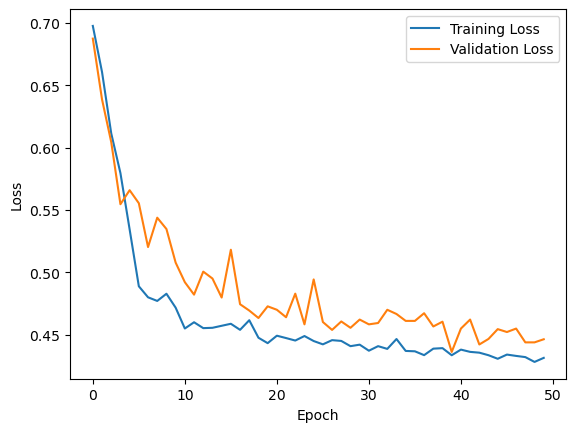

In [14]:
from torch.nn import CrossEntropyLoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = CrossEntropyLoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Training phase
for epoch in trange(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :]
        loss = loss_fun(outputs, labels.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

    
    # Validation phase
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1)
            outputs, _, _ = net(inputs)
            outputs = outputs[:, -1, :]
            loss = loss_fun(outputs, labels.long())
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))  

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()